In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.neural_network import MLPRegressor
import torch
from torch.nn import *
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from warnings import filterwarnings
filterwarnings("ignore")

def calc_spread_return_per_day(df, portfolio_size=200, toprank_weight_ratio=2):
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size=200, toprank_weight_ratio=2):
    buf = df.groupby('Date').apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio, buf

In [3]:
train_stock_prices = pd.read_csv("./train_files/stock_prices.csv")

In [4]:
train_stock_prices.drop(['ExpectedDividend'], axis=1, inplace=True)
train_stock_prices.drop(['RowId'], axis=1, inplace=True)
train_stock_prices.drop(['SupervisionFlag'], axis=1, inplace=True)
train_stock_prices.drop(['AdjustmentFactor'], axis=1, inplace=True)

In [5]:
t = train_stock_prices.copy()

In [6]:
t.sort_values(by=['SecuritiesCode','Date'], inplace=True)
t['Open'].interpolate(inplace=True)
t['High'].interpolate(inplace=True)
t['Low'].interpolate(inplace=True)
t['Close'].interpolate(inplace=True)
t.loc[t['Volume'] == 0,"Volume"] = np.nan
t['Volume'].interpolate(inplace=True)
t['Target'].interpolate(inplace=True)

In [7]:
codes = t.SecuritiesCode.unique()
new_codes = dict(zip(codes, np.arange(2000)))
t = t.replace({'SecuritiesCode' : new_codes})

In [8]:
features = ['SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume'] 
target = 'Target'

In [9]:
train_df = t.loc[t.Date < t.Date.unique()[-100], [*features, target]]
test_df = t.loc[t.Date >= t.Date.unique()[-100], [*features, target]]
X_train = train_df[features].to_numpy()
y_train = train_df[target].to_numpy()
X_test = test_df[features].to_numpy()
y_test = test_df[target].to_numpy()

In [10]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y).unsqueeze(1)
 
    def __len__(self):
        return len(self.X)
 
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [11]:
batchSize = 128
dataset_train = Dataset(X_train, y_train)
dataset_test = Dataset(X_test, y_test)
train_dl = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=False)
test_dl = torch.utils.data.DataLoader(dataset_test, batch_size=batchSize, shuffle=False)

In [177]:
class MLP(torch.nn.Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        emb_size = 32
        self.layer1 = Linear(emb_size+n_inputs, 100)
        self.layer2 = Linear(100, 100)
        self.layer3 = Linear(100, 1)
        self.activation = LeakyReLU()
        self.embedding = torch.rand([2000, emb_size], requires_grad=True).to(device)
        self.layerEmb = Linear(emb_size, emb_size)
        self.batchNorm1 = BatchNorm1d(n_inputs+emb_size)
        self.batchNorm2 = BatchNorm1d(100)
        self.batchNorm3 = BatchNorm1d(100)
        self.dropout = Dropout(p=0.2)
 
    def forward(self, X):
        codes = X[:, 0].long()
        X = X[:, 1:]
        emb = self.embedding[codes]
        #emb = self.activation(self.layerEmb(emb))
        
        X = torch.cat((X, emb), 1)
        X = self.batchNorm1(X)
        X = self.activation(self.layer1(X))
        X = self.dropout(X)
        X = self.batchNorm2(X)
        X = self.activation(self.layer2(X))
        X = self.dropout(X)
        X = self.batchNorm3(X)
        X = self.layer3(X)
        return X

In [178]:
model = MLP(len(features) - 1).to(device)

In [179]:
criterion = torch.nn.L1Loss()   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, min_lr=1e-6, factor=0.5)

In [180]:
start_time = datetime.now()

for epoch in range(10):
    train_loss = 0
    model.train()
    for i, (inputs, targets) in enumerate(train_dl):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        yhat = model(inputs)
        loss = criterion(yhat, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss
        
    model.eval()
    
    with torch.no_grad():
        eval_loss = 0
        for i, (inputs, targets) in enumerate(test_dl):
            inputs, targets = inputs.to(device), targets.to(device)
            yhat = model(inputs)
            loss = criterion(yhat, targets)
            eval_loss += loss
        
    scheduler.step(eval_loss)
    
    if epoch % 1 == 0:
        print("Epoch: " + str(epoch) + ", train loss: " + str(train_loss/len(train_dl)) + ", eval loss: " + str(eval_loss/len(test_dl)))

print(datetime.now() - start_time)

Epoch: 0, train loss: tensor(0.0256, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.2940, device='cuda:0')
Epoch: 1, train loss: tensor(0.0156, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.4231, device='cuda:0')
Epoch: 2, train loss: tensor(0.0156, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.2443, device='cuda:0')
Epoch: 3, train loss: tensor(0.0155, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.2209, device='cuda:0')
Epoch: 4, train loss: tensor(0.0155, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.2062, device='cuda:0')
Epoch: 5, train loss: tensor(0.0155, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0677, device='cuda:0')


KeyboardInterrupt: 

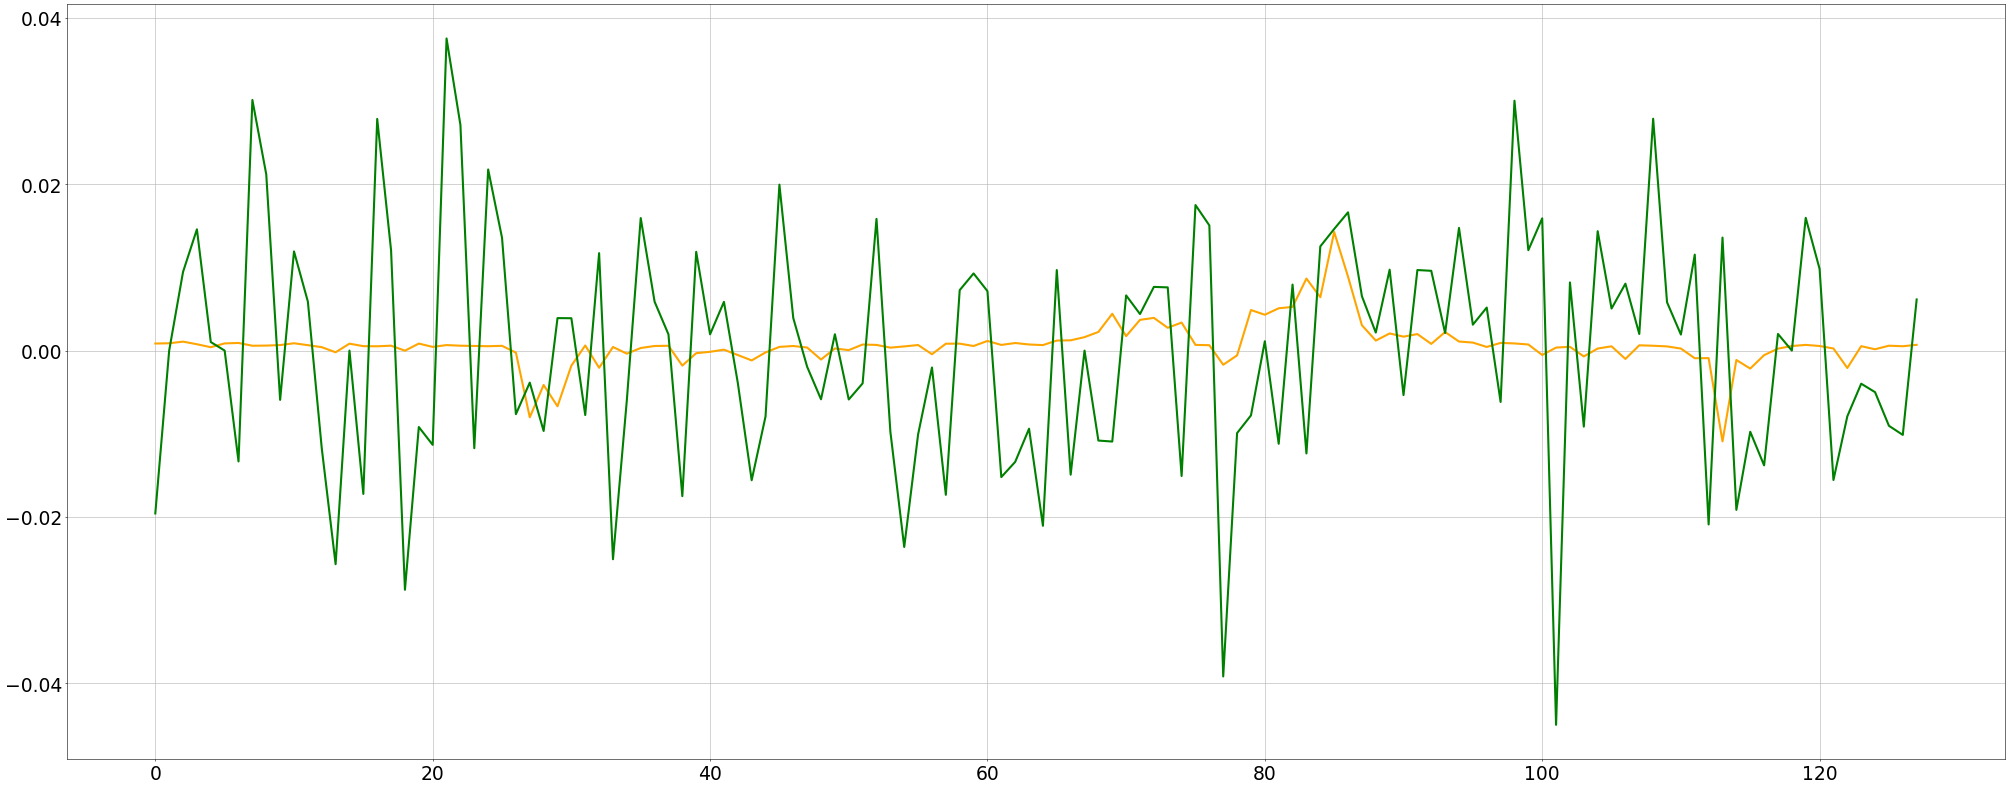

In [181]:
fig1, ax1 = plt.subplots(figsize=(50, 20), dpi=50)
ax1.tick_params(axis='y', which='both', labeltop='on', labelbottom='off', labelsize=27)
ax1.tick_params(axis='x', labelbottom='off', labelsize=27)
ax1.grid()
ax1.plot(yhat.cpu().detach().numpy(), lw=3, color='orange')
ax1.plot(targets.cpu().detach().numpy(), lw=3, color='green')

In [182]:
pricesSup = pd.read_csv('./supplemental_files/stock_prices.csv', parse_dates=["Date"])
# pricesSup = pricesSup.replace({'SecuritiesCode' : new_codes})
# pricesSup.sort_values(by=['SecuritiesCode','Date'], inplace=True)
# pricesSup['Open'].interpolate(inplace=True)
# pricesSup['High'].interpolate(inplace=True)
# pricesSup['Low'].interpolate(inplace=True)
# pricesSup['Close'].interpolate(inplace=True)
# pricesSup.loc[pricesSup['Volume'] == 0,"Volume"] = np.nan
# pricesSup['Volume'].interpolate(inplace=True)

In [183]:
with torch.no_grad():
    for date in pricesSup.Date.unique():
        x = torch.Tensor(pricesSup.loc[pricesSup.Date==date, [*features]].to_numpy()).to(device)
        pred = model(x)
        pricesSup.loc[pricesSup.Date==date, "Prediction"] = pred.cpu().detach().numpy()
        pricesSup.loc[pricesSup.Date==date, "Rank"] = pricesSup.loc[pricesSup.Date==date, "Prediction"].rank(ascending=False, method="first") - 1
        pricesSup.loc[pricesSup.Date==date, "Rank"] = pricesSup.loc[pricesSup.Date==date, "Rank"].astype("int")

sharpe_ratio, buf = calc_spread_return_sharpe(pricesSup)
sharpe_ratio

0.19742770131619397

In [184]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
     
lgbm_model = LGBMRegressor()
lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
score = np.sqrt(mean_squared_error(y_test, y_pred))
print(score)

0.022250003497599563


In [187]:
with torch.no_grad():
    for date in pricesSup.Date.unique():
        x = pricesSup.loc[pricesSup.Date==date, [*features]].to_numpy()
        lgbm_pred = lgbm_model.predict(x)
        
        x = torch.Tensor(x).to(device)
        mlp_pred = model(x).cpu().detach().numpy().squeeze(1)
        
        pricesSup.loc[pricesSup.Date==date, "Prediction"] = mlp_pred*0.5 + 0.5*lgbm_pred
        pricesSup.loc[pricesSup.Date==date, "Rank"] = pricesSup.loc[pricesSup.Date==date, "Prediction"].rank(ascending=False, method="first") - 1
        pricesSup.loc[pricesSup.Date==date, "Rank"] = pricesSup.loc[pricesSup.Date==date, "Rank"].astype("int")
        
sharpe_ratio, buf = calc_spread_return_sharpe(pricesSup)
sharpe_ratio

-0.08225556627875967

In [188]:
buf, buf.mean()

(Date
 2021-12-06    1.521908
 2021-12-07    0.263162
 2021-12-08   -1.185371
 2021-12-09   -1.037334
 2021-12-10   -1.617105
 2021-12-13    0.057008
 2021-12-14    0.379968
 2021-12-15   -2.188411
 2021-12-16    0.016647
 2021-12-17   -0.107725
 2021-12-20    1.910416
 2021-12-21    0.214207
 2021-12-22    0.660290
 2021-12-23   -1.380554
 2021-12-24   -1.032650
 2021-12-27    1.762475
 2021-12-28    0.316439
 2021-12-29   -1.231010
 2021-12-30   -2.633411
 2022-01-04   -2.828840
 2022-01-05   -0.581914
 2022-01-06   -1.561066
 2022-01-07    1.619517
 2022-01-11   -1.817910
 2022-01-12   -0.501509
 2022-01-13   -1.436211
 2022-01-14    0.860537
 2022-01-17   -1.667647
 2022-01-18    2.137694
 2022-01-19   -0.456108
 2022-01-20    0.048169
 2022-01-21   -3.255038
 2022-01-24    1.340088
 2022-01-25   -4.429184
 2022-01-26   -0.521591
 2022-01-27    2.288139
 2022-01-28    1.296379
 2022-01-31    2.397872
 2022-02-01   -2.045603
 2022-02-02   -0.381868
 2022-02-03   -2.654970
 2022-02-0